# استيراد المكتبات اللازمة

In [1]:
# Import Needed Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import warnings
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
import json
from deap import base, creator, tools
from tensorflow.keras.callbacks import EarlyStopping


warnings.filterwarnings('ignore')

# تثبيت البذور العشوائية لضمان ثبات النتائج

In [2]:

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'




# تحميل البيانات

In [3]:

data = np.load('Segmented_data.npz')

# استرجاع المصفوفات
x_train = data['x_train']
y_train = data['y_train']
x_val = data['x_val']
y_val = data['y_val']
x_test= data['x_test']
y_test= data['y_test']
class_names = data['class_names'] 
num_classes= data['num_classes']
print("Class names:", class_names,"num_classes",num_classes)
print(f"عدد عينات التدريب المختارة: {x_train.shape[0]}")
print(f"عدد عينات التحقق المختارة: {x_val.shape[0]}")
print(f"عدد عينات الاختبار المختارة: {x_test.shape[0]}")

Class names: ['CRVO' 'DME' 'OTHER'] num_classes 3
عدد عينات التدريب المختارة: 3190
عدد عينات التحقق المختارة: 684
عدد عينات الاختبار المختارة: 684


# تحويل x_train و x_test إلى مصفوفات NumPy

In [4]:

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test=np.array(x_test)
# الآن يمكنك الحصول على أبعاد البيانات
print("Initial shape or dimensions of x_train:", x_train.shape)


Initial shape or dimensions of x_train: (3190, 128, 128, 3)


# توضيح توزيع الفئات

In [5]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# حساب توزيع الفئات في مجموعة التدريب
train_classes, train_counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print("Distribution in training set:")
for cls, count in zip(train_classes, train_counts):
    print(f"Class {cls} ({class_names[cls]}): {count} samples")

# حساب توزيع الفئات في مجموعة التحقق
val_classes, val_counts = np.unique(np.argmax(y_val, axis=1), return_counts=True)
print("\nDistribution in validation set:")
for cls, count in zip(val_classes, val_counts):
    print(f"Class {cls} ({class_names[cls]}): {count} samples")

# حساب توزيع الفئات في مجموعة الاختبار
test_classes, test_counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print("\nDistribution in test set:")
for cls, count in zip(test_classes, test_counts):
    print(f"Class {cls} ({class_names[cls]}): {count} samples")


Distribution in training set:
Class 0 (CRVO): 1098 samples
Class 1 (DME): 1118 samples
Class 2 (OTHER): 974 samples

Distribution in validation set:
Class 0 (CRVO): 235 samples
Class 1 (DME): 240 samples
Class 2 (OTHER): 209 samples

Distribution in test set:
Class 0 (CRVO): 235 samples
Class 1 (DME): 240 samples
Class 2 (OTHER): 209 samples


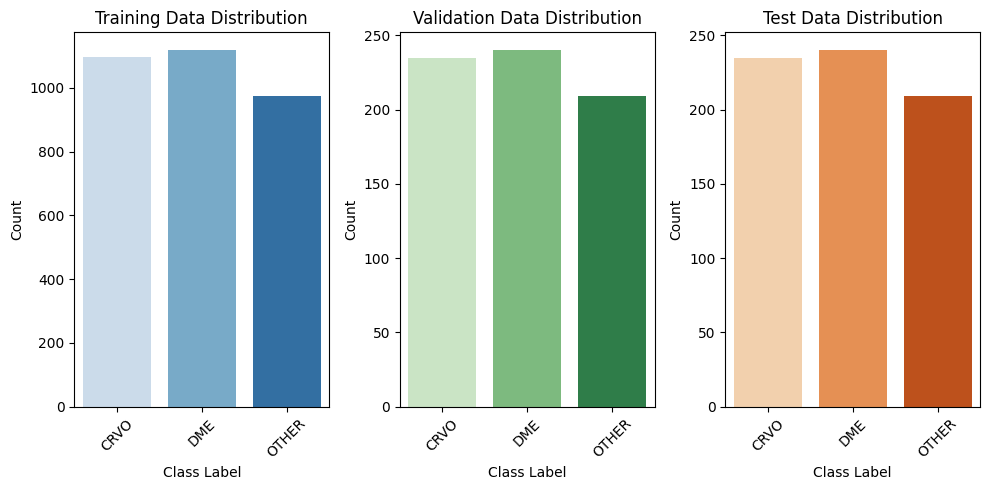

In [6]:


# تحويل التسميات إلى أرقام إذا لم تكن قد فعلت ذلك
y_train_labels1 = np.argmax(y_train, axis=1)
y_val_labels1 = np.argmax(y_val, axis=1)
y_test_labels1 = np.argmax(y_test, axis=1)

# إنشاء DataFrame للتوزيع
train_counts = pd.Series(y_train_labels1).value_counts().sort_index()
val_counts = pd.Series(y_val_labels1).value_counts().sort_index()
test_counts = pd.Series(y_test_labels1).value_counts().sort_index()

# استبدال الترميز بأسماء الفئات
train_counts.index = [class_names[i] for i in train_counts.index]
val_counts.index = [class_names[i] for i in val_counts.index]
test_counts.index = [class_names[i] for i in test_counts.index]

# رسم التوزيعات باستخدام seaborn
plt.figure(figsize=(10, 5))

# توزيع بيانات التدريب
plt.subplot(1, 3, 1)
sns.barplot(x=train_counts.index, y=train_counts.values, palette="Blues")
plt.title("Training Data Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(rotation=45)  # لتدوير أسماء الفئات إذا كانت طويلة

# توزيع بيانات التحقق
plt.subplot(1, 3, 2)
sns.barplot(x=val_counts.index, y=val_counts.values, palette="Greens")
plt.title("Validation Data Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# توزيع بيانات الاختبار
plt.subplot(1, 3, 3)
sns.barplot(x=test_counts.index, y=test_counts.values, palette="Oranges")
plt.title("Test Data Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# عرض الرسم
plt.tight_layout()
plt.show()


# فحص مجموعة البيانات لدينا

In [7]:
# Inspecting our Dataset
print("Initial shape or dimensions of x_train", str(x_train.shape))

# Print the number of samples in our data
print ("Number of samples in our training data: " + str(len(x_train)))
print ("Number of labels in our training data: " + str(len(y_train)))
print ("Number of samples in our val data: " + str(len(x_val)))
print ("Number of labels in our val data: " + str(len(y_val)))

Initial shape or dimensions of x_train (3190, 128, 128, 3)
Number of samples in our training data: 3190
Number of labels in our training data: 3190
Number of samples in our val data: 684
Number of labels in our val data: 684


In [ ]:


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128).prefetch(tf.data.AUTOTUNE)


val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128).prefetch(tf.data.AUTOTUNE)


##############################################################################
# 1) تعريف الـ Fitness والـ Individual
##############################################################################

In [9]:
import random
import json
import tensorflow as tf
from deap import base, creator, tools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, 
                                     BatchNormalization, Activation, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop


input_shape=(128, 128, 3)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()



##############################################################################
# 2) تسجيل المعاملات في الخوارزمية الجينية (GA)
##############################################################################

In [10]:

# ثلاثة معاملات لأعداد الفلاتر في كل بلوك Conv
toolbox.register("block1_filters", random.choice, [32, 64, 128])  
toolbox.register("block2_filters", random.choice, [32, 64, 128])
toolbox.register("block3_filters", random.choice, [32, 64, 128])

# معدل الإسقاط Dropout
toolbox.register("dropout_rate", random.uniform, 0.2,0.5)

# معاملتان لعدد الوحدات في الطبقات Dense 

toolbox.register("dense1_units", random.choice, [128, 256, 512])
toolbox.register("dense2_units", random.choice, [64, 128, 256])

# معدل التعلّم
toolbox.register("learning_rate", random.uniform, 0.00001, 0.001)

# اسم الـ Optimizer
toolbox.register("optimizer", random.choice, ['adam', 'adamax', 'sgd', 'rmsprop'])


# تجميع المعاملات كلها في فرد (Individual)
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    (
      toolbox.block1_filters,
      toolbox.block2_filters,
      toolbox.block3_filters,
      toolbox.dropout_rate,
      toolbox.dense1_units,
      toolbox.dense2_units,
      toolbox.learning_rate,
      toolbox.optimizer,
    ),
    n=1
)

# إنشاء السكان
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


##############################################################################
# 3) دالة بناء النموذج (مع L2 Regularization)
##############################################################################

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, 
                                     BatchNormalization, Activation, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.optimizers import Adam, Adamax, SGD, RMSprop

def create_cnn_model(individual, input_shape, num_classes):
    """
    individual ترتيب المعاملات:
    0: block1_filters
    1: block2_filters
    2: block3_filters
    3: dropout_rate
    4: dense1_units
    5: dense2_units
    6: learning_rate
    7: optimizer
 
    """

    # فك شيفرة المعاملات
    block1_filters, block2_filters, block3_filters, dropout_rate, \
    dense1_units, dense2_units, learning_rate, chosen_optimizer, \
    = individual
    
    # اختيار الـ Optimizer بناءً على القيمة المختارة
    if chosen_optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif chosen_optimizer == 'adamax':
        optimizer_instance = Adamax(learning_rate=learning_rate)
    elif chosen_optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    elif chosen_optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    else:
        # بشكل احتياطي
        optimizer_instance = Adam(learning_rate=learning_rate)
    
    model = Sequential()
    
    # ---------------- Block 1 ---------------- #
    model.add(Conv2D(block1_filters, (3, 3), 
                     padding='same', 
                     input_shape=input_shape,
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(block1_filters, (3, 3), 
                     padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    # ---------------- Block 2 ---------------- #
    model.add(Conv2D(block2_filters, (3, 3), 
                     padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(block2_filters, (3, 3),
                     padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    # ---------------- Block 3 ---------------- #
    model.add(Conv2D(block3_filters, (3, 3), 
                     padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(block3_filters, (3, 3), 
                     padding='same',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(dropout_rate))


    # ---------------- Flatten & Dense ---------------- #
    model.add(Flatten())

    model.add(Dense(dense1_units, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(dense2_units, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # ---------------- Output Layer ---------------- #
    model.add(Dense(num_classes, activation='softmax',
                    kernel_regularizer=tf.keras.regularizers.l2(1e-4)))

    # ---------------- Compile ---------------- #
    model.compile(optimizer=optimizer_instance,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


##############################################################################
# 4) دالة التقييم
##############################################################################

In [ ]:
evaluated_individuals = {}
import pandas as pd


def evaluate(individual):
    global best_accuracy, evaluated_individuals

    # تحويل الفرد إلى tuple لاستخدامه كمفتاح في القاموس
    individual_key = tuple(individual)

    # التحقق مما إذا تم تقييم هذا الفرد مسبقاً
    if individual_key in evaluated_individuals:
        return evaluated_individuals[individual_key]

    # نبني الموديل بناءً على المعاملات
    model = create_cnn_model(individual, input_shape=input_shape, num_classes=num_classes)

    # تعريف Callback مخصص لتتبع أفضل دقة تحقق أثناء التدريب
    class BestAccuracyCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(BestAccuracyCallback, self).__init__()
            self.best_val_acc = 0

        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            val_acc = logs.get('val_accuracy')
            if val_acc is not None and val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
   
    best_acc_callback = BestAccuracyCallback()


    # ندرب النموذج مع إضافة الـ Callback الجديد
    history = model.fit(
        train_dataset,
        epochs=60,
        validation_data=val_dataset,
        verbose=0,
        callbacks=[ best_acc_callback],
    )

    # نستخدم أفضل دقة تحقق تم الوصول إليها أثناء التدريب
    accuracy = best_acc_callback.best_val_acc
 
    # تحديث أفضل نموذج إذا كانت الدقة الحالية أعلى
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model.save('best_model.keras')
    
        # حفظ برامترات النموذج الأفضل
        params = {
            'block1_filters': individual[0],
            'block2_filters': individual[1],
            'block3_filters': individual[2],
            'dropout_rate': individual[3],
            'dense1_units': individual[4],
            'dense2_units': individual[5],
            'learning_rate': individual[6],
            'optimizer': individual[7],
            'accuracy': best_accuracy
        }
        with open('best_model_params.json', 'w') as f:
            json.dump(params, f)
        print(f"Model saved with accuracy: {best_accuracy:.4f}")
        # إنشاء DataFrame أفقي: الصف الأول لأسماء المعاملات، والصف الثاني للقيم
        horizontal_df = pd.DataFrame([list(params.keys()), list(params.values())],
                             index=["Parameter", "Value"])

# تنسيق الجدول: تقليل حجم الخط، توسيط النص، وتقليل حواف الخلايا
        styled_df = (horizontal_df.style
                .set_properties(**{'text-align': 'center', 'font-size': '11px', 'padding': '5px'})
                .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center'),
                                                              ('font-size', '11px'),
                                                              ('padding', '5px')]}]) )

        display(styled_df)

    # تخزين النتيجة في القاموس لتفادي التكرار في المستقبل
    evaluated_individuals[individual_key] = (accuracy,)
    return (accuracy,)

toolbox.register("evaluate", evaluate)

       



##############################################################################
# 5) عمليات التهجين (Crossover) والطفرة (Mutation) والاختيار (Selection)
##############################################################################

In [ ]:


def custom_crossover(ind1, ind2):
   
    for i in range(len(ind1)):
        if random.random() < 0.8:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2


def custom_mutation(ind):
 
    for i in range(len(ind)):
        gene = ind[i]
        
        # (0,1,2) => blockX_filters
        if i in [0, 1, 2]:
            if random.random() < 0.2:
                ind[i] = random.choice([32, 64, 128])
        
        # (3) => dropout_rate (float)
        elif i == 3:
            if random.random() < 0.2:
                new_val = gene + random.uniform(-0.05, 0.05)
                new_val = max(0.0, min(new_val, 1.0))
                ind[i] = new_val
        
        # (4,5) => denseX_units
        elif i in [4, 5]:
            if random.random() < 0.2:
                if i == 4:  # dense1_units
                    ind[i] = random.choice([128, 256, 512])
                else:       # dense2_units
                    ind[i] = random.choice([64, 128, 256])
        
        # (6) => learning_rate (float)
        elif i == 6:
            if random.random() < 0.2:
                new_val = gene + random.uniform(-0.0005, 0.0005)
                new_val = max(1e-7, new_val)
                ind[i] = new_val

        # (7) => optimizer (string)
        elif i == 7:
            if random.random() < 0.2:
                ind[i] = random.choice(['adam', 'adamax', 'sgd', 'rmsprop'])
    
    return ind,


toolbox.register("mate", custom_crossover)
toolbox.register("mutate", custom_mutation)
toolbox.register("select", tools.selTournament, tournsize=3)




##############################################################################
# 6) الجزء الرئيسي لتشغيل الخوارزمية الجينية
##############################################################################

In [ ]:
import time

start_time = time.time()
def main():
    global best_accuracy
    best_accuracy = 0.0

    preset_individual = creator.Individual([
        32,            # block1_filters
        64,            # block2_filters
        128,           # block3_filters
        0.25,          # dropout_rate
        256,           # dense1_units
        128,           # dense2_units
        1e-4,          # learning_rate
        'adam',        # optimizer
    ])
    # إنشاء السكان الأولي مع الفرد المخصص
    def create_population_with_preset(preset, population_size):
        # إنشاء السكان بشكل عشوائي
        random_population = toolbox.population(n=population_size - 1)
        # إضافة الفرد المخصص في البداية
        return [preset] + random_population
    

    # إنشاء السكان
    population = create_population_with_preset(preset_individual, 10)
    # حجم السكان (مثال)
    generations = 20  # عدد الأجيال (مثال)

    for gen in range(generations):
        print(f"Generation {gen + 1}...")

        # قيّم كل فرد (Individual) في السكان
        fitnesses = []
        for idx, ind in enumerate(population, start=1):
            print(f" Processing Individual {idx} ...")  #  طباعة قبل التقييم
            fit = toolbox.evaluate(ind)
            fitnesses.append(fit)
            ind.fitness.values = fit

        #  **ترتيب السكان تصاعديًا حسب اللياقة**
        population.sort(key=lambda ind: ind.fitness.values[0])

        # استخراج أفضل فرد  من الجيل الحالي
        elite = toolbox.clone(population[-1])

        # إعادة ترتيب السكان كل 5 أجيال لمنع الوقوع في الحد المحلي
        if gen % 5 == 0:
            random.shuffle(population)
        # اختيار الأبناء
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # إجراء التهجين
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.8:  # احتمال التهجين
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        # إجراء الطفرة
        for mutant in offspring:
            if random.random() < 0.2:  # احتمال الطفرة
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # التأكد من تمرير أفضل فرد  إلى الجيل التالي
        offspring[-1] = elite

        # استبدال السكان بالأبناء
        population[:] = offspring

    return population


if __name__ == '__main__':
    final_pop = main()
end_time = time.time()
print(f" وقت المعالجة: {end_time - start_time:.2f} ثانية")


Generation 1...
 Processing Individual 1 ...
Model saved with accuracy: 0.6769


,0,1,2,3,4,5,6,7,8
Parameter,block1_filters,block2_filters,block3_filters,dropout_rate,dense1_units,dense2_units,learning_rate,optimizer,accuracy
Value,32,64,128,0.250000,256,128,0.000100,adam,0.676901


 Processing Individual 2 ...
Model saved with accuracy: 0.7807


,0,1,2,3,4,5,6,7,8
Parameter,block1_filters,block2_filters,block3_filters,dropout_rate,dense1_units,dense2_units,learning_rate,optimizer,accuracy
Value,128,32,32,0.422465,128,64,0.000148,adam,0.780702


 Processing Individual 3 ...
 Processing Individual 4 ...
Model saved with accuracy: 0.9006


,0,1,2,3,4,5,6,7,8
Parameter,block1_filters,block2_filters,block3_filters,dropout_rate,dense1_units,dense2_units,learning_rate,optimizer,accuracy
Value,32,128,128,0.207961,128,256,0.000653,rmsprop,0.900585


 Processing Individual 5 ...
 Processing Individual 6 ...
 Processing Individual 7 ...
Model saved with accuracy: 0.9079


,0,1,2,3,4,5,6,7,8
Parameter,block1_filters,block2_filters,block3_filters,dropout_rate,dense1_units,dense2_units,learning_rate,optimizer,accuracy
Value,64,64,128,0.279356,128,256,0.000465,adam,0.907895


 Processing Individual 8 ...
 Processing Individual 9 ...
Model saved with accuracy: 0.9167


,0,1,2,3,4,5,6,7,8
Parameter,block1_filters,block2_filters,block3_filters,dropout_rate,dense1_units,dense2_units,learning_rate,optimizer,accuracy
Value,128,32,128,0.220867,512,64,0.000775,adam,0.916667


 Processing Individual 10 ...
Generation 2...
 Processing Individual 1 ...
 Processing Individual 2 ...
 Processing Individual 3 ...
 Processing Individual 4 ...
 Processing Individual 5 ...
 Processing Individual 6 ...
 Processing Individual 7 ...
 Processing Individual 8 ...
 Processing Individual 9 ...
 Processing Individual 10 ...
Generation 3...
 Processing Individual 1 ...
 Processing Individual 2 ...
 Processing Individual 3 ...
 Processing Individual 4 ...
 Processing Individual 5 ...
 Processing Individual 6 ...
 Processing Individual 7 ...
 Processing Individual 8 ...
 Processing Individual 9 ...
 Processing Individual 10 ...
Generation 4...
 Processing Individual 1 ...
 Processing Individual 2 ...
 Processing Individual 3 ...
 Processing Individual 4 ...
 Processing Individual 5 ...
 Processing Individual 6 ...
 Processing Individual 7 ...
 Processing Individual 8 ...
 Processing Individual 9 ...
 Processing Individual 10 ...
Generation 5...
 Processing Individual 1 ...
 Pro

,0,1,2,3,4,5,6,7,8
Parameter,block1_filters,block2_filters,block3_filters,dropout_rate,dense1_units,dense2_units,learning_rate,optimizer,accuracy
Value,128,128,128,0.255370,256,64,0.000775,adam,0.919591


 Processing Individual 4 ...
 Processing Individual 5 ...
 Processing Individual 6 ...
 Processing Individual 7 ...
 Processing Individual 8 ...
 Processing Individual 9 ...
 Processing Individual 10 ...
Generation 10...
 Processing Individual 1 ...
 Processing Individual 2 ...
 Processing Individual 3 ...
 Processing Individual 4 ...
 Processing Individual 5 ...
 Processing Individual 6 ...
 Processing Individual 7 ...
 Processing Individual 8 ...
 Processing Individual 9 ...
 Processing Individual 10 ...
Generation 11...
 Processing Individual 1 ...
 Processing Individual 2 ...
 Processing Individual 3 ...
 Processing Individual 4 ...
 Processing Individual 5 ...
 Processing Individual 6 ...
 Processing Individual 7 ...
 Processing Individual 8 ...
 Processing Individual 9 ...
 Processing Individual 10 ...
Generation 12...
 Processing Individual 1 ...
 Processing Individual 2 ...
 Processing Individual 3 ...
 Processing Individual 4 ...
 Processing Individual 5 ...
 Processing Indivi

In [41]:
import json

# 1) تحميل البرامترات الأفضل
with open('best_model_params.json', 'r') as f:
    best_params = json.load(f)

# 2) استخراج القيم
block1_filters = best_params['block1_filters']
block2_filters = best_params['block2_filters']
block3_filters = best_params['block3_filters']
dropout_rate = best_params['dropout_rate']
dense1_units = best_params['dense1_units']
dense2_units = best_params['dense2_units']
learning_rate = best_params['learning_rate']
optimizer_name = best_params['optimizer']

# 3) ضبط عدد التصنيفات وشكل المدخلات (حدِّثها حسب بياناتك)
num_classes = 3
input_shape = (128, 128, 3)

# 4) تشكيل الفرد (Individual) بالترتيب نفسه
individual = [
    block1_filters,
    block2_filters ,
    block3_filters,
    dropout_rate,
    dense1_units,
    dense2_units,
    learning_rate,
    optimizer_name

]

# 5) استدعاء دالّة بناء النموذج
final_model = create_cnn_model(individual, 
                               input_shape=input_shape, 
                               num_classes=num_classes)

# 6) عرض ملخّص النموذج
print(final_model.summary())


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_402 (Conv2D)          (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization_536 (Bat (None, 128, 128, 128)     512       
_________________________________________________________________
activation_402 (Activation)  (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_403 (Conv2D)          (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_537 (Bat (None, 128, 128, 128)     512       
_________________________________________________________________
activation_403 (Activation)  (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d_201 (MaxPoolin (None, 64, 64, 128)     

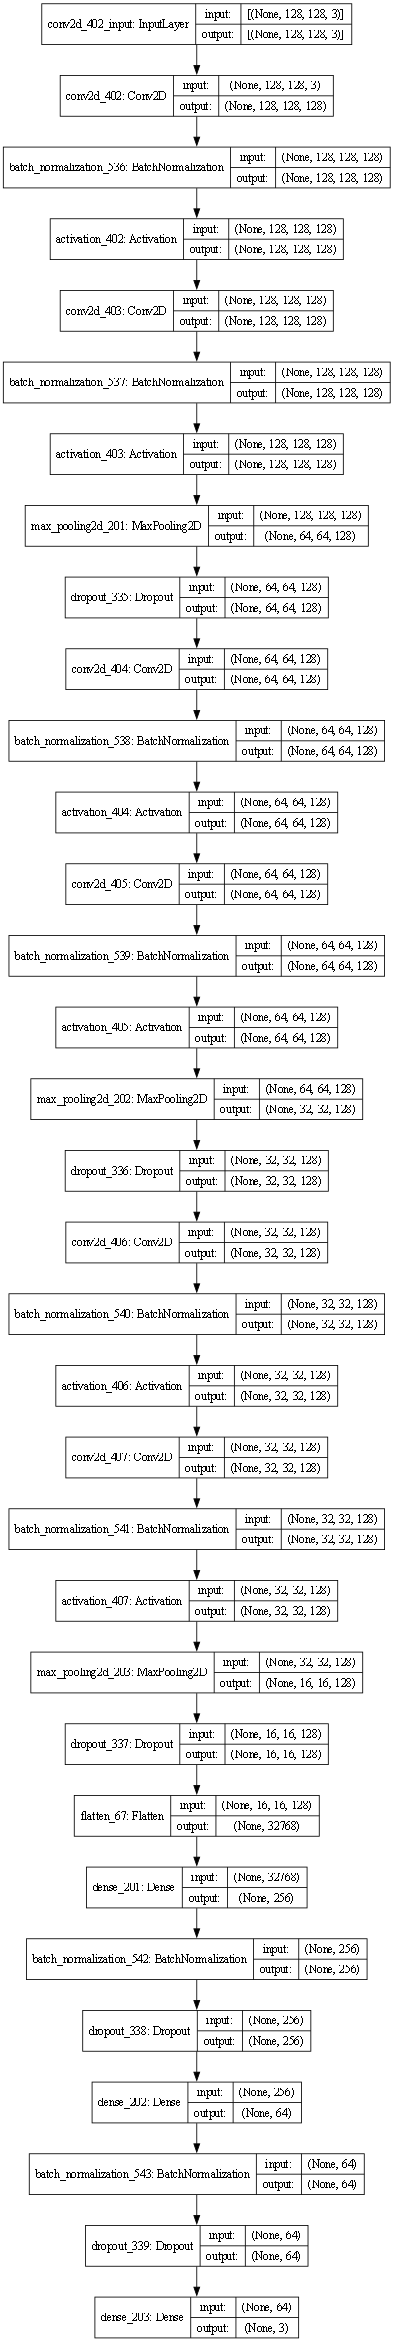

In [42]:
from tensorflow.keras.utils import plot_model

plot_model(
    final_model, dpi=60,
    show_shapes=True
)

In [43]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# تحويل تسميات التدريب إلى فئات
y_train_classes = np.argmax(y_train, axis=1)

# حساب أوزان الفئات مرة واحدة
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)

# تحويل الأوزان إلى قاموس لاستخدامه مع Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# إعداد كولباك لتخفيض معدل التعلم عند عدم تحسن الأداء
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# إعداد كولباك لحفظ أفضل نموذج فقط عند تحسن val_accuracy
checkpoint = ModelCheckpoint(
    'best_model_2.h5',  # اسم الملف لحفظ النموذج
    monitor='val_accuracy',  # المتغير الذي سيتم مراقبته
    save_best_only=True,  # يحفظ النموذج فقط إذا تحسنت الدقة
    mode='max',  # لأننا نريد أعلى قيمة لـ val_accuracy
    verbose=1  # طباعة رسالة عند حفظ النموذج
)

# **تأكد من تعريف final_model قبل استدعاء fit()**


# تدريب النموذج مع أوزان الفئات المحسوبة مسبقًا
history = final_model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=125,
    validation_data=(x_val, y_val),
    class_weight=class_weight_dict,  # يتم تثبيت الأوزان هنا
    verbose=1,
    callbacks=[ reduce_lr,checkpoint]  # إضافة كولباك لحفظ أفضل نموذج
)

# تحميل أفضل نموذج تم حفظه
best_model = load_model('best_model_2.h5')

# تقييم النموذج الأفضل على بيانات التحقق
val_loss, val_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
print(f"Best model validation accuracy: {val_accuracy:.4f}")


Class weights: {0: 0.9684274438372799, 1: 0.951103160405486, 2: 1.0917180013689254}
Epoch 1/125
100/100 [==============================] - 8s 69ms/step - loss: 1.0313 - accuracy: 0.6624 - val_loss: 1.5216 - val_accuracy: 0.3056

Epoch 00001: val_accuracy improved from -inf to 0.30556, saving model to best_model_2.h5
Epoch 2/125
100/100 [==============================] - 7s 67ms/step - loss: 0.8613 - accuracy: 0.7047 - val_loss: 1.7194 - val_accuracy: 0.3056

Epoch 00002: val_accuracy did not improve from 0.30556
Epoch 3/125
100/100 [==============================] - 7s 67ms/step - loss: 0.7956 - accuracy: 0.7245 - val_loss: 1.4783 - val_accuracy: 0.5556

Epoch 00003: val_accuracy improved from 0.30556 to 0.55556, saving model to best_model_2.h5
Epoch 4/125
100/100 [==============================] - 7s 67ms/step - loss: 0.7503 - accuracy: 0.7455 - val_loss: 1.1220 - val_accuracy: 0.5804

Epoch 00004: val_accuracy improved from 0.55556 to 0.58041, saving model to best_model_2.h5
Epoch 5/

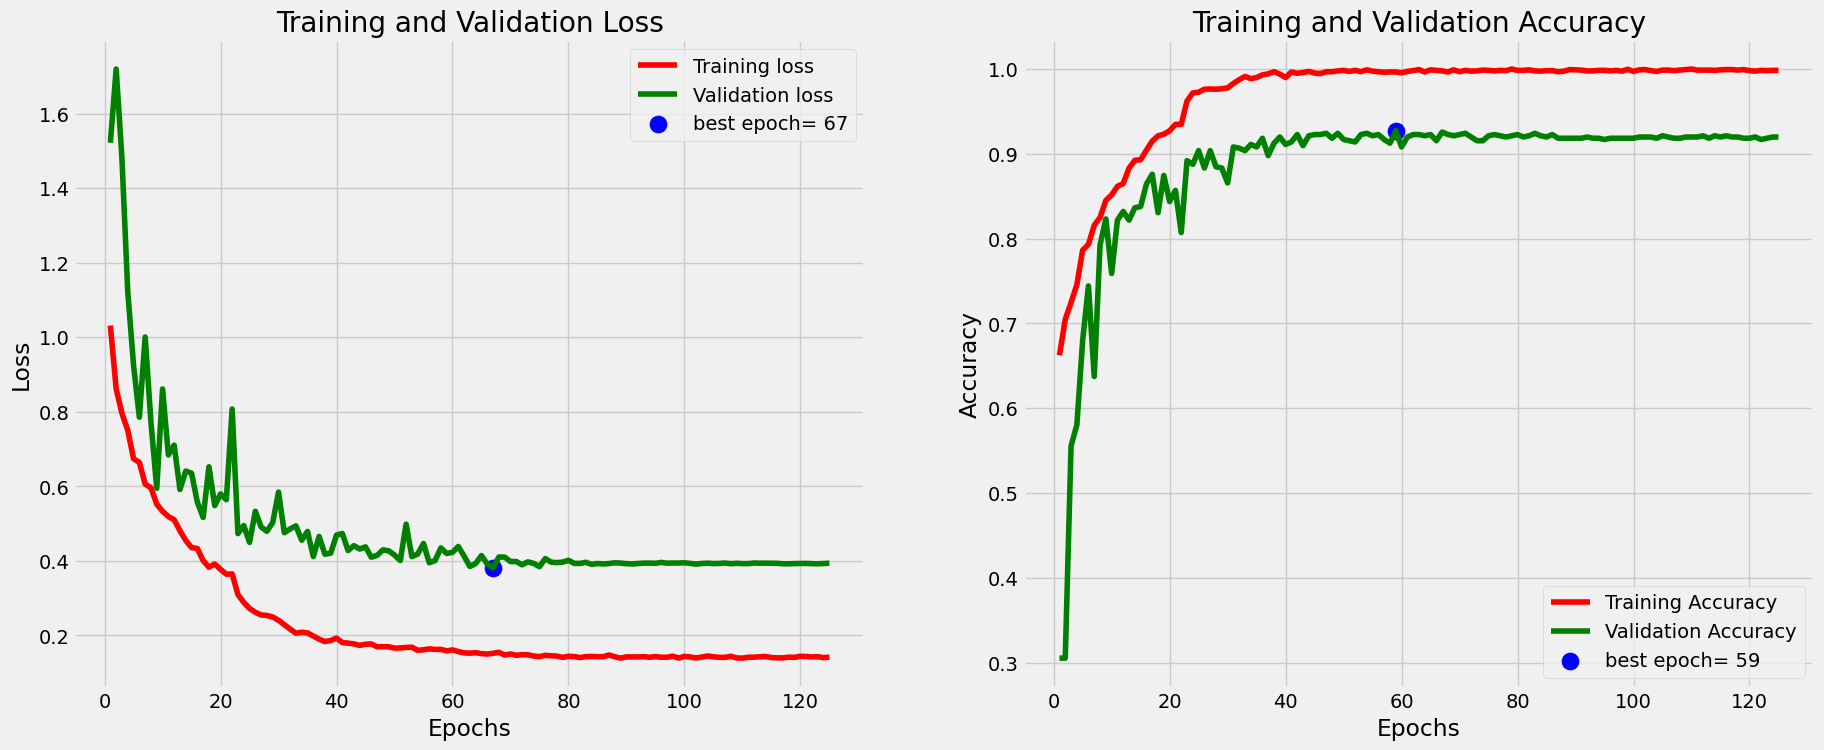

In [44]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(history)


# تقييم النموذج

Classification Report:
               precision    recall  f1-score   support

        CRVO       0.95      0.89      0.92       235
         DME       0.89      0.97      0.92       240
       OTHER       0.96      0.93      0.94       209

    accuracy                           0.93       684
   macro avg       0.93      0.93      0.93       684
weighted avg       0.93      0.93      0.93       684



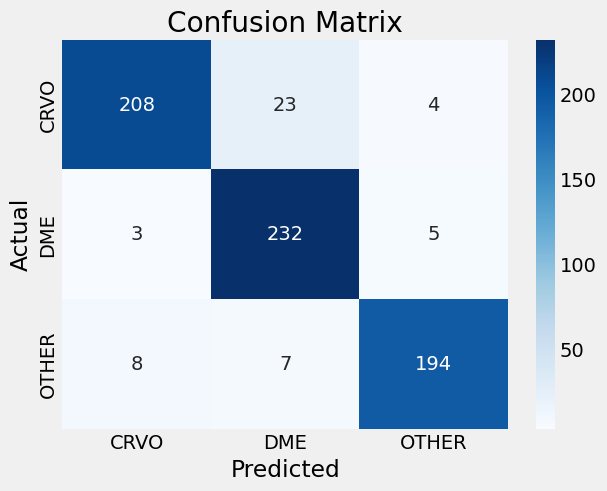

In [45]:

y_pred = best_model.predict(x_val) 
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# طباعة التقرير التصنيفي

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# رسم المصفوفة التشوشية (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


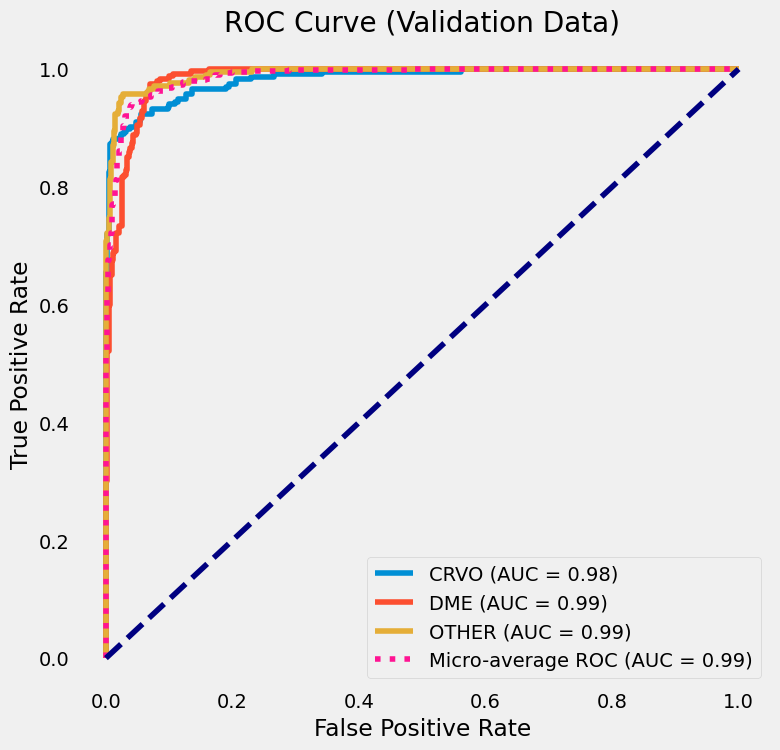

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# أسماء الفئات


# تحويل y_val إلى ترميز one-hot إذا كانت على شكل أرقام
if len(y_val.shape) == 1:
    y_val_onehot = label_binarize(y_val, classes=np.arange(len(class_names)))
else:
    y_val_onehot = y_val

# الحصول على احتمالات التنبؤ من النموذج
y_val_pred = best_model.predict(x_val)

# عدد الفئات
n_classes = y_val_onehot.shape[1]

# حساب منحنى ROC و AUC لكل فئة
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_onehot[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# حساب ROC للميكرو (micro-average)
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_onehot.ravel(), y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# رسم منحنيات ROC
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

# إضافة منحنى الميكرو
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    color="deeppink", linestyle=":", linewidth=4
)

# خط القاعدة
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve (Validation Data)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# تقييم النموذج على بيانات الاختبار

Classification Report:
               precision    recall  f1-score   support

        CRVO       0.96      0.89      0.92       235
         DME       0.90      0.97      0.93       240
       OTHER       0.91      0.90      0.91       209

    accuracy                           0.92       684
   macro avg       0.92      0.92      0.92       684
weighted avg       0.92      0.92      0.92       684



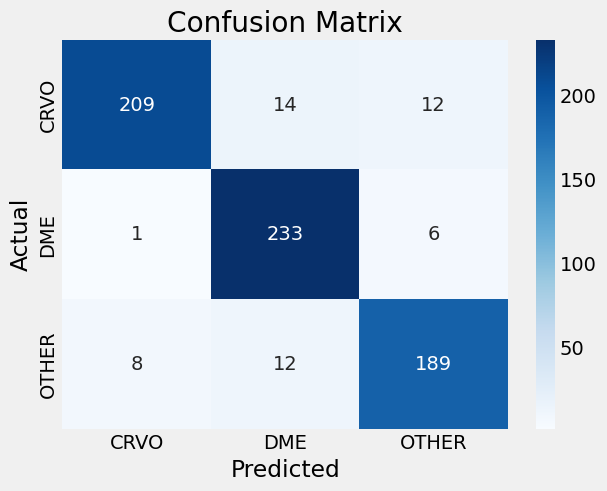

Model Accuracy: 0.92251


In [47]:
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# حساب الدقة بدقة الأعشار
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.5f}")  # طباعة الدقة حتى منزلة عشرية واحدة


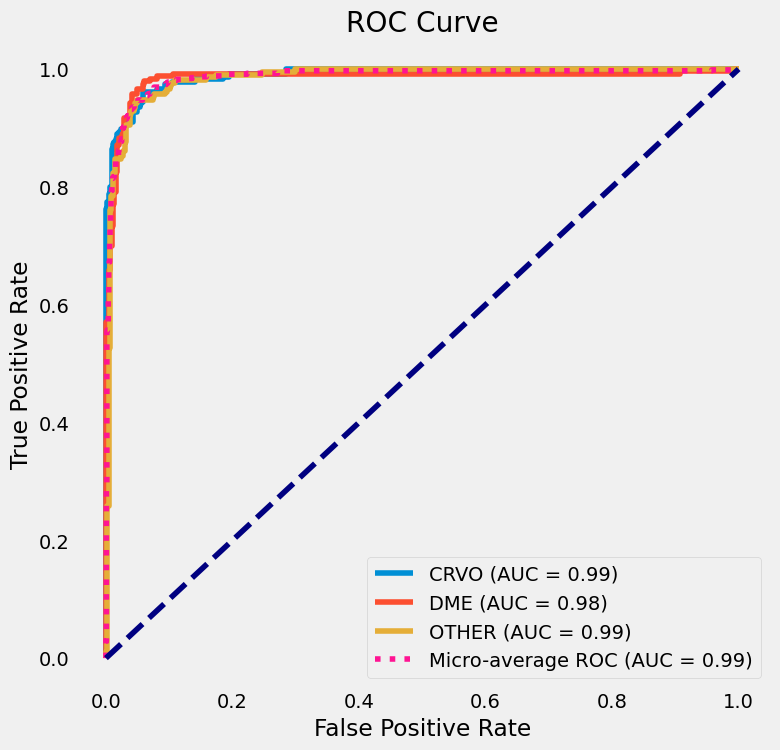

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np



# تحويل y_test إلى ترميز one-hot إذا كانت على شكل أرقام
if len(y_test.shape) == 1:
    y_test_onehot = label_binarize(y_test, classes=np.arange(len(class_names)))
else:
    y_test_onehot = y_test

# الحصول على احتمالات التنبؤ من النموذج
y_pred = best_model.predict(x_test)

# عدد الفئات
n_classes = y_test_onehot.shape[1]

# حساب منحنى ROC و AUC لكل فئة
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# حساب ROC للميكرو (micro-average)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# رسم منحنيات ROC
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

# إضافة منحنى الميكرو
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
    color="deeppink", linestyle=":", linewidth=4
)

# خط القاعدة
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# حفظ النموذج

In [50]:


# حفظ النموذج باستخدام الطريقة الصحيحة
best_model.save('best_model_g.keras')



